# Evaluation for Kirk Experiment

In [17]:
import sys
from omegaconf import OmegaConf, DictConfig
from typing import Union, Dict, Optional

sys.path.append("../..")
folder_train = "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/exp_sweep/2022-07-01/14-14-50_benchmark_train/"
folder_eval = (
    "/home/benjamin/Dokumente/code/tmp/tntcomp/CARL/multirun/2022-07-06/17-21-44"
)
folder_eval = "/home/benjamin/Dokumente/code/tmp/CARL/multirun/2022-07-07/07-57-17/"


def recover_traincfg_from_wandb(
    fn_wbcfg: str, to_dict: bool = False
) -> Optional[Union[DictConfig, Dict]]:
    wbcfg = OmegaConf.load(fn_wbcfg)
    if not "traincfg" in wbcfg:
        return None
    traincfg = wbcfg.traincfg
    traincfg = OmegaConf.to_container(cfg=traincfg, resolve=False, enum_to_str=True)[
        "value"
    ]
    traincfg = ast.literal_eval(traincfg)
    traincfg = OmegaConf.create(traincfg)
    if to_dict:
        traincfg = OmegaConf.to_container(cfg=traincfg, resolve=True, enum_to_str=True)
    return traincfg

In [43]:
from rich import print as printr
from rich.progress import track
import pickle
from pathlib import Path
import numpy as np
import ast
import pandas as pd
from tqdm import tqdm
from wandb.sdk.wandb_helper import parse_config
from experiments.common.utils.json_utils import lazy_json_load
from experiments.evaluation.run_evaluation import find_multirun_paths


def load_wandb_table(fn: Union[str, Path]) -> pd.DataFrame:
    data = lazy_json_load(fn)
    data = pd.DataFrame(data=np.array(data["data"]), columns=data["columns"])
    return data


reload_rpc: bool = False

fn_config = ".hydra/config.yaml"
fn_wbsummary = "wandb/latest-run/files/wandb-summary.json"
fn_wbconfig = "wandb/latest-run/files/config.yaml"
rpc_fn = Path("rpc.csv")
if not rpc_fn.is_file():
    reload_rpc = True

paths = find_multirun_paths(result_dir=folder_eval)

entries = []
rpc_list = []
for i, p in tqdm(enumerate(paths)):
    p = Path(p)
    fn_cfg = p / fn_config
    fn_wbsum = p / fn_wbsummary
    fn_wbcfg = p / fn_wbconfig
    if not fn_wbcfg.is_file() or not fn_wbsum.is_file() or not fn_cfg.is_file():
        continue
    cfg = OmegaConf.load(fn_cfg)
    traincfg = recover_traincfg_from_wandb(fn_wbcfg)
    summary = lazy_json_load(fn_wbsum)

    if traincfg is not None:
        mode = traincfg.kirk_evaluation_protocol.mode
    else:
        mode = cfg.kirk_evaluation_protocol.mode
    if "average_return" in summary:
        average_return = summary["average_return"]
    else:
        average_return = None

    if mode is None or average_return is None:
        continue

    distribution_type = cfg.kirk_evaluation_protocol.distribution_type
    entry = {
        "mode": mode,
        "distribution_type": distribution_type,
        "average_return": average_return,
    }
    entries.append(entry)

    if reload_rpc:
        path_to_table = fn_wbsum.parent / summary["return_per_context_table"]["path"]
        return_per_context = load_wandb_table(path_to_table)

        contexts_path = fn_wbsum.parent / summary["evalpost/contexts"]["path"]
        contexts = load_wandb_table(contexts_path)

        visibility = traincfg.wandb.group

        context_ids = return_per_context["context_id"].apply(int).to_list()
        contexts_to_table = pd.DataFrame([contexts.iloc[cidx] for cidx in context_ids])
        for col in contexts_to_table.columns:
            return_per_context[col] = contexts_to_table[col].to_numpy()
        n = len(return_per_context)
        return_per_context["mode"] = [mode] * n
        return_per_context["distribution_type"] = [distribution_type] * n
        return_per_context["average_return"] = [average_return] * n
        return_per_context["visibility"] = visibility
        rpc_list.append(return_per_context)

    # if i == 10:
    #     break

df = pd.DataFrame(entries)
if reload_rpc:
    df_rpc = pd.concat(rpc_list)
    df_rpc.to_csv(rpc_fn)
else:
    df_rpc = pd.read_csv(rpc_fn)

600it [01:08,  8.77it/s]


In [19]:
# Plotting definitions
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

vmin = 300  # df_rpc["return"].min()
vmax = 500  # df_rpc["return"].max()
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

In [ ]:
grid = sns.FacetGrid(df, col="mode", height=6)
grid.map(sns.barplot, "distribution_type", "average_return")

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

xlabel = "gravity"
ylabel = "pole_length"
figsize = (8, 6)
dpi = 200
# grid = sns.FacetGrid(df_rpc, col="mode", height=6, hue="distribution_type")
# grid.map(sns.scatterplot, xlabel, ylabel, style="return")

# for i, (mode, ax) in enumerate(grid.axes_dict.items()):
#     print(i)
# print(list(grid.facet_data()))

group_key = "mode"
groups = df_rpc.groupby(group_key)
n_groups = len(groups)
fig = plt.figure(figsize=figsize, dpi=dpi)
axes = fig.subplots(nrows=1, ncols=n_groups, sharex=True, sharey=True)
cmap = "viridis"
for i, (group_id, df) in enumerate(groups):
    print(i, group_id)
    ax = axes[i]
    ax.scatter(
        x=df[xlabel], y=df[ylabel], c=df["average_return"], s=1, norm=norm, cmap=cmap
    )
    ax.set_box_aspect(1)

    # break
    if i == n_groups - 1:
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
fig.set_tight_layout(True)

plt.show()

# Plot Heatmaps
  (0, 0) origin       9     gravity     11
    X------------------->
    |  0.6
    |
    |
    |  pole_length
    |
    |
    |
    V  0.4

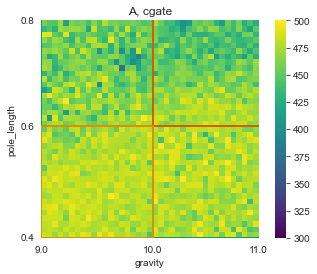

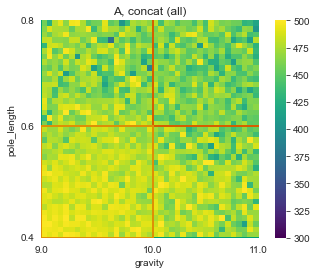

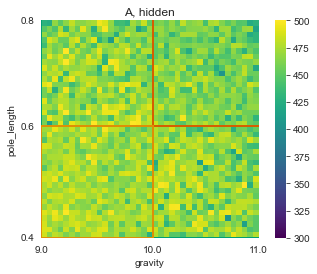

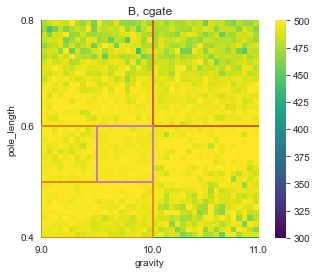

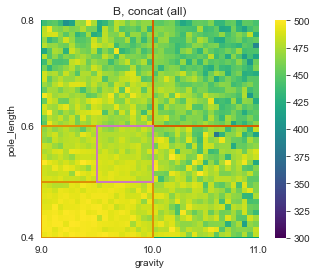

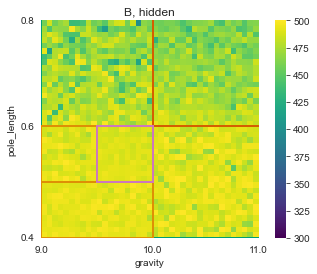

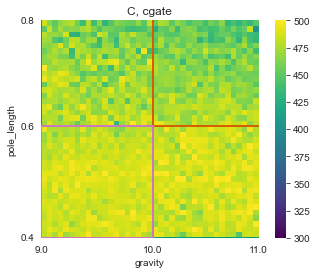

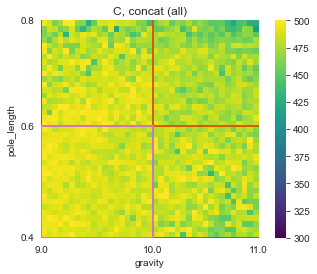

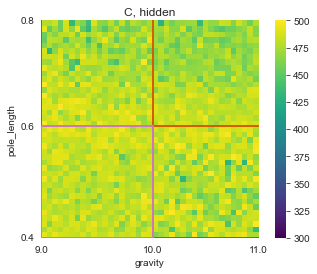

In [48]:
from copy import copy
from hydra.utils import instantiate
from experiments.evaluation_protocol.plot_evaluate_on_protocol import get_ep_mplpatches

traincfg = recover_traincfg_from_wandb(p.parent / "0" / fn_wbconfig)

plt.rcParams["axes.grid"] = False

df = df_rpc
n_bins = 40
discretizer = {
    "pole_length": (0.4, 0.8, n_bins),  # rows of heatmap
    "gravity": (9, 11, n_bins),  # cols of heatmap
}
filter_distribution_types = [
    "train",
    # "test_interpolation",
    # "test_interpolation_combinatorial",
    # "test_extrapolation_single",
    # "test_extrapolation_all"
]
for fil in filter_distribution_types:
    df = df[df["distribution_type"] != fil]

context_features = [
    instantiate(config=cf) for cf in traincfg.kirk_evaluation_protocol.context_features
]
context_features_bins = []
for cf in context_features:
    cf = copy(cf)
    def transform(v: float) -> float:
        return (v - cf.lower) / (cf.upper - cf.lower) * n_bins

    vals_to_discretize = [cf.lower, cf.lower_constraint, cf.mid, cf.upper]
    transformed = [transform(v) for v in vals_to_discretize]
    cf.lower, cf.lower_constraint, cf.mid, cf.upper = transformed
    context_features_bins.append(cf)

cmap = copy(plt.cm.viridis)
cmap.set_bad(color="k")

group_keys = ["mode", "visibility"]  # , "distribution_type"]
groups = df.groupby(group_keys)
for group_id, group_df in groups:
    mode = group_id[group_keys.index("mode")]
    for key, args in discretizer.items():
        bins = np.linspace(*args)
        ids = np.digitize(group_df[key].to_numpy(), bins=bins) - 1
        discretized = [bins[i] for i in ids]
        group_df[key + "_discrete"] = discretized
        group_df[key + "_id"] = ids

    # reduce dataframe by average over same contexts
    reduced = group_df.groupby([k + "_id" for k in discretizer.keys()]).mean()
    heatmap = np.zeros((n_bins - 1, n_bins - 1))

    for idx in reduced.index:
        row = reduced.loc[idx]
        ret = row["return"]
        heatmap[idx] = ret

    heatmap[heatmap == 0] = np.nan

    patches = get_ep_mplpatches(
        context_features=context_features_bins,
        draw_frame=True,
        mode=mode,
        patch_kwargs=dict(linewidth=2),
    )

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax = sns.heatmap(heatmap, ax=ax, cmap=cmap, norm=norm)
    ax.set_box_aspect(1)
    ax.invert_yaxis()

    # ticks
    cf0, cf1 = context_features_bins
    xticks = [cf0.lower, cf0.mid, cf0.upper - 1]
    yticks = [cf1.lower, cf1.mid, cf1.upper - 1]
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)

    cf0, cf1 = context_features
    xticklabels = [cf0.lower, cf0.mid, cf0.upper]
    yticklabels = [cf1.lower, cf1.mid, cf1.upper]
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_yticklabels(yticklabels, rotation=0)

    ax.set_ylabel(list(discretizer.keys())[0])
    ax.set_xlabel(list(discretizer.keys())[1])

    # ax.axis("off")
    for patch in patches:
        ax.add_patch(patch)
    ax.set_title(", ".join(group_id))
    plt.show()